In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8703703703703703, Loss: 0.7487360636393229
Checkpoint 20, Accuracy: 0.9012345679012346, Loss: 0.6263510386149088
Checkpoint 30, Accuracy: 0.8703703703703703, Loss: 0.5668122326886212
Checkpoint 40, Accuracy: 0.8950617283950617, Loss: 0.5075269628454138
Checkpoint 50, Accuracy: 0.8827160493827161, Loss: 0.40481687475133826
Checkpoint 60, Accuracy: 0.9506172839506173, Loss: 0.31380483839246964
Checkpoint 70, Accuracy: 0.9506172839506173, Loss: 0.29004778685393157
Checkpoint 80, Accuracy: 0.9444444444444444, Loss: 0.2710476804662634
Checkpoint 90, Accuracy: 0.9753086419753086, Loss: 0.23776506494592736
Checkpoint 100, Accuracy: 0.9629629629629629, Loss: 0.2243409686618381
Checkpoint 110, Accuracy: 0.9691358024691358, Loss: 0.16830216513739693
Checkpoint 120, Accuracy: 0.9691358024691358, Loss: 0.15422609117296007
Checkpoint 130, Accuracy: 0.9753086419753086, Loss: 0.12528171362700286
Checkpoint 140, Accuracy: 0.9567901234567902, Loss: 0.13643029001024035
Checkpo

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

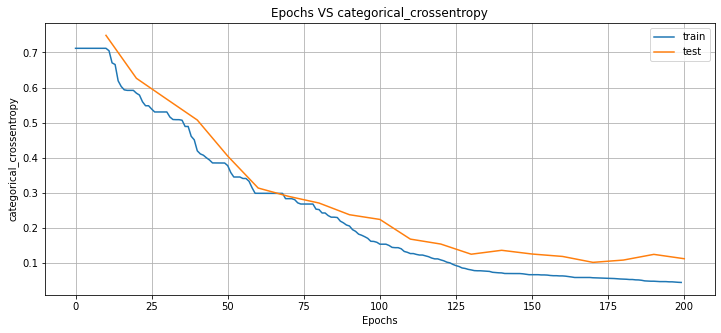

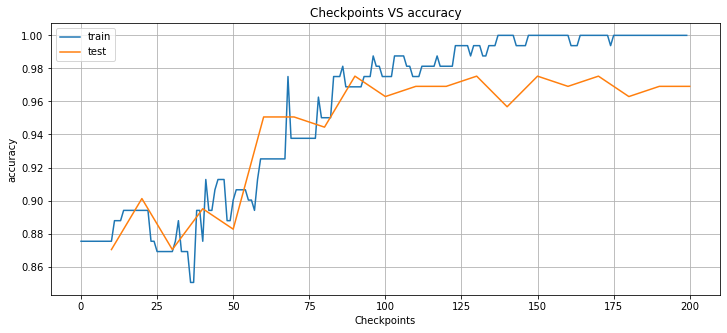

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.97320956 0.0057744  0.021016  ]
[0. 1. 0.] <-> [2.8714577e-02 9.7123837e-01 4.7112524e-05]
[1. 0. 0.] <-> [0.94199663 0.00402689 0.05397648]
[1. 0. 0.] <-> [0.9881471  0.00504916 0.00680375]
[1. 0. 0.] <-> [9.8908418e-01 1.0006668e-02 9.0923347e-04]
[1. 0. 0.] <-> [0.8343609  0.00286793 0.16277114]
[1. 0. 0.] <-> [9.6334624e-01 3.6127154e-02 5.2663364e-04]
[1. 0. 0.] <-> [0.9876902  0.00663836 0.0056714 ]
[1. 0. 0.] <-> [9.8650670e-01 1.2620206e-02 8.7307667e-04]
[0. 1. 0.] <-> [2.9910558e-01 7.0065242e-01 2.4193089e-04]
[1. 0. 0.] <-> [9.8085165e-01 1.8383279e-02 7.6503109e-04]
[1. 0. 0.] <-> [0.9157384 0.0038077 0.0804539]
[1. 0. 0.] <-> [8.7921512e-01 1.2025742e-01 5.2749779e-04]
[1. 0. 0.] <-> [0.9894029  0.00958873 0.00100827]
[1. 0. 0.] <-> [9.6380270e-01 3.5563663e-02 6.3364970e-04]
[1. 0. 0.] <-> [9.7117484e-01 2.8299397e-02 5.2575063e-04]
[0. 1. 0.] <-> [9.4898202e-02 9.0495092e-01 1.5097228e-04]
[0. 0. 1.] <-> [9.9044368e-03 3.7537382e-05 9.9005800e-01]
[1. 

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8703703703703703, 'mean_square_error': 0.39869161026565725, 'categorical_crossentropy': 0.7487360636393229, 'essential_metrics': {0: {'tp_hit': 71, 'fp_hit': 16, 'tn_hit': 16, 'fn_hit': 5}, 1: {'tp_hit': 16, 'fp_hit': 5, 'tn_hit': 86, 'fn_hit': 1}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}}, 'checkpoint': 10} 


{'accuracy': 0.9012345679012346, 'mean_square_error': 0.30064889524950805, 'categorical_crossentropy': 0.6263510386149088, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 16, 'tn_hit': 16, 'fn_hit': 0}, 1: {'tp_hit': 16, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 1}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}}, 'checkpoint': 20} 


{'accuracy': 0.8703703703703703, 'mean_square_error': 0.3143821157453462, 'categorical_crossentropy': 0.5668122326886212, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 21, 'tn_hit': 11, 'fn_hit': 0}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 6}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-2.3506405   3.          3.          1.6401091  -0.47757038]
 bias: -3.0

Neuron 1: weights:
[ 1.91142    -2.268446   -1.3742833   1.83236     0.03963032]
 bias: -2.8135080337524414

Neuron 2: weights:
[-0.04323674  2.0590303   1.4835454  -1.0121926  -0.43417555]
 bias: -0.8476963639259338

Neuron 3: weights:
[-0.2577903   3.          0.82463986 -0.45673695 -1.782074  ]
 bias: 3.0

$
Layer 2
Neuron 0: weights:
[-3.         -2.3833096  -0.19692935  3.        ]
 bias: 3.0

Neuron 1: weights:
[ 3.        -3.         3.         2.2834458]
 bias: -1.958919644355774

Neuron 2: weights:
[-0.8699512  3.        -1.9619845 -3.       ]
 bias: 2.222224712371826

$

